In [1]:
""" 
21 MARCH 2024 
Theo Gauvrit
Testing if the responsivity pattern are different between WT and KO groups
"""

import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import percephone.plts.behavior as pbh
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
import percephone.analysis.mlr_models as mlr_m
from multiprocessing import Pool, cpu_count, pool
plt.rcParams['font.size'] = 400
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline

In [2]:
user = "Théo"

if user == "Célien":
    directory = "C:/Users/cvandromme/Desktop/Data/"
    roi_path = "C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx"
elif user == "Théo":
    directory = "/datas/Théo/Projects/Percephone/data/Amplitude_Detection/loop_format_tau_02/"
    roi_path = directory + "/FmKO_ROIs&inhibitory.xlsx"
    
roi_info = pd.read_excel(roi_path)
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

def opening_rec(fil, i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, roi_path)
    return rec

workers = cpu_count()
if user == "Célien":
    pool = pool.ThreadPool(processes=workers)
elif user == "Théo":
    pool = Pool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file, i)) for i, file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}


Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.

Behavioural information already incorporated in the analog.

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.


In [3]:
def fraction_resp( pattern, n_type, ko):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = np.array(rec.matrices[n_type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim]
        trials_undetected = resp_mat[:,~rec.detected_stim]
        if pattern == 0:
            trials_detected[trials_detected!=0]=1
            trials_undetected[trials_undetected!=0]=1
        else:
            trials_detected[trials_detected!=pattern]=0
            trials_undetected[trials_undetected!=pattern]=0

        recruited_det = np.count_nonzero(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if  n_type== "INH":
            total_n = len(rec.zscore_inh)
        perc_n_det = (np.mean(recruited_det)/total_n)*100
        #undetected
        recruited_undet = np.count_nonzero(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/total_n)*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
        elif rec.genotype == "KO" and ko =="KO":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    return wt_det, ko_det, wt_undet, ko_undet

# Comparison WT vs KO (including ko-Hypo)


## Fraction of neurons recruited (1 and -1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9563702940940857, pvalue=0.7749032378196716)
ShapiroResult(statistic=0.8672791123390198, pvalue=0.215573251247406)
LeveneResult(statistic=0.0037419754969961016, pvalue=0.9522294987457793)
Equal variances :Ttest_indResult(statistic=0.9262814932155242, pvalue=0.37255406965328797)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.96978360414505, pvalue=0.8963048458099365)
ShapiroResult(statistic=0.7247058153152466, pvalue=0.011140274815261364)
MannwhitneyuResult(statistic=17.0, pvalue=0.4135864135864136)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6384268403053284, pvalue=0.00044495885958895087)
ShapiroResult(statistic=0.8629014492034912, pvalue=0.19934488832950592)
MannwhitneyuResult(statistic=27.0, pvalue=0.7466165820041419)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7365221977233887, pvalue=0.005788878072053194)
ShapiroResult(statistic=0.9886937141418457, pvalue=0.98574906

Text(0.5, 0.98, 'Percentage of exc neurons recruited (1 and -1) during stimulus detected and undetected')

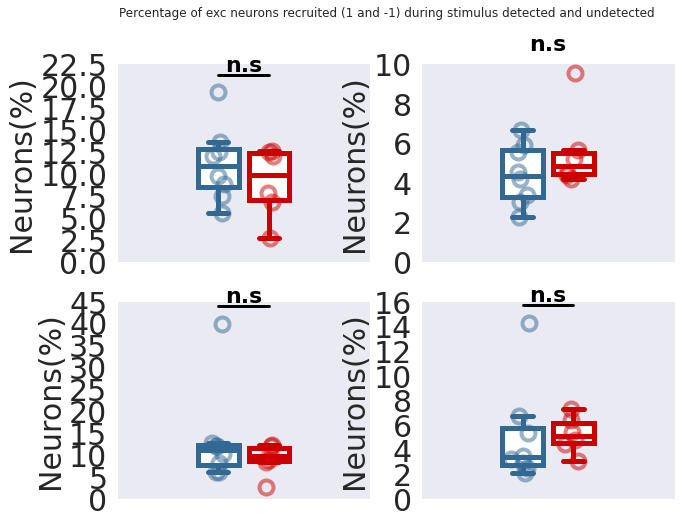

In [4]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=0, n_type="EXC", ko="KO")
fig, axs = plt.subplots(2,2,figsize=(10,8))
ppt.boxplot(axs[0,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[0,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=0, n_type="INH", ko="KO")
ppt.boxplot(axs[1,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
fig.suptitle("Percentage of exc neurons recruited (1 and -1) during stimulus detected and undetected")


## Fraction of neurons activated (1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9193118810653687, pvalue=0.4243049919605255)
ShapiroResult(statistic=0.8654273748397827, pvalue=0.208578422665596)
LeveneResult(statistic=0.6605075247753601, pvalue=0.43220944200950157)
Equal variances :Ttest_indResult(statistic=0.5893279733791914, pvalue=0.5665712137541703)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9659343361854553, pvalue=0.8643363118171692)
ShapiroResult(statistic=0.7286540865898132, pvalue=0.012215977534651756)
MannwhitneyuResult(statistic=20.0, pvalue=0.662004662004662)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8610727787017822, pvalue=0.1230647936463356)
ShapiroResult(statistic=0.9474071860313416, pvalue=0.7192444205284119)
LeveneResult(statistic=1.2939574091481454, pvalue=0.27752348018908873)
Equal variances :Ttest_indResult(statistic=0.7259360500357422, pvalue=0.48179720013654936)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.807933866977691

Text(0.5, 0.98, 'Percentage of exc neurons activated (1) during stimulus detected and undetected')

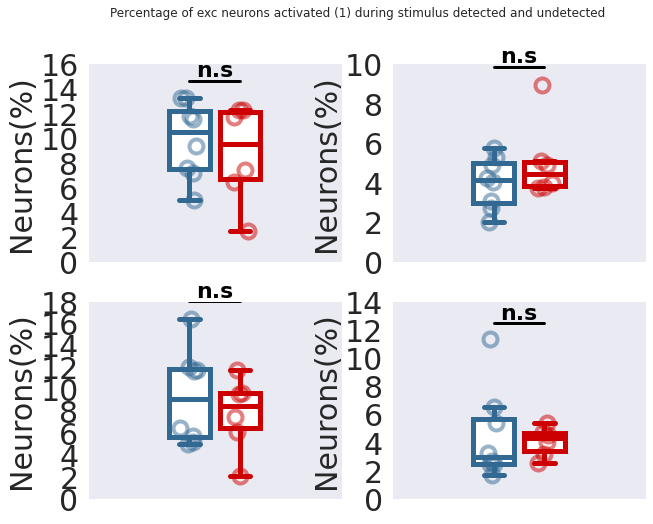

In [5]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=1, n_type="EXC", ko="KO")
fig, axs = plt.subplots(2,2,figsize=(10,8))
ppt.boxplot(axs[0,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[0,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=1, n_type="INH", ko="KO")
ppt.boxplot(axs[1,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
fig.suptitle("Percentage of exc neurons activated (1) during stimulus detected and undetected")


## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5672472715377808, pvalue=6.551777187269181e-05)
ShapiroResult(statistic=0.9180660843849182, pvalue=0.4915425181388855)
MannwhitneyuResult(statistic=38.0, pvalue=0.08125208125208126)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8501535058021545, pvalue=0.09561086446046829)
ShapiroResult(statistic=0.9340283274650574, pvalue=0.6115500330924988)
LeveneResult(statistic=0.027842370501194157, pvalue=0.8702586519071187)
Equal variances :Ttest_indResult(statistic=-0.5366486248905694, pvalue=0.601318156821255)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5439731478691101, pvalue=3.471325180726126e-05)
ShapiroResult(statistic=0.8048738241195679, pvalue=0.06498847156763077)
MannwhitneyuResult(statistic=29.0, pvalue=0.5727605727605728)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.669510006904602, pvalue=0.0010134369367733598)
ShapiroResult(statistic=0.7208652496337891, pvalue=0.01017

Text(0.5, 0.98, 'Percentage of exc neurons inhibited (-1) during stimulus detected and undetected')

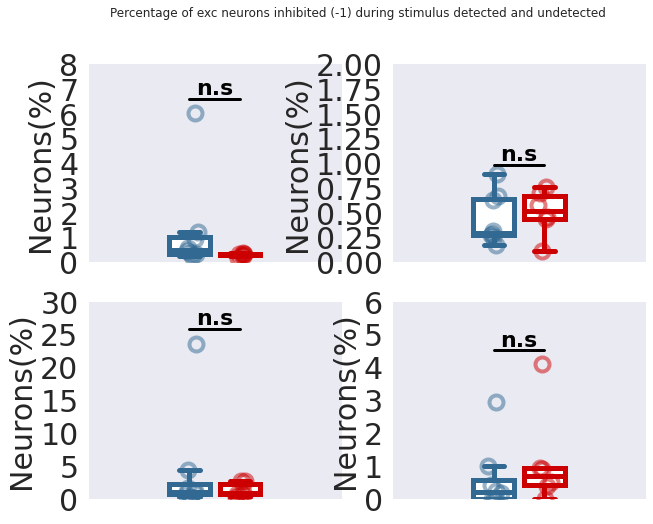

In [6]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=-1, n_type="EXC", ko="KO")
fig, axs = plt.subplots(2,2,figsize=(10,8))
ppt.boxplot(axs[0,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[0,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=-1, n_type="INH", ko="KO")
ppt.boxplot(axs[1,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
fig.suptitle("Percentage of exc neurons inhibited (-1) during stimulus detected and undetected")

# Comparison WT vs Ko-Hypo

## Fraction of neurons recruited ( 1 and -1) 


Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9563702940940857, pvalue=0.7749032378196716)
ShapiroResult(statistic=0.8880429267883301, pvalue=0.37412503361701965)
LeveneResult(statistic=0.12779253684953737, pvalue=0.7281614292224192)
Equal variances :Ttest_indResult(statistic=0.9876554647873169, pvalue=0.34661568537384524)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.96978360414505, pvalue=0.8963048458099365)
ShapiroResult(statistic=0.6697325706481934, pvalue=0.004861507099121809)
MannwhitneyuResult(statistic=12.0, pvalue=0.5696969696969697)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6384268403053284, pvalue=0.00044495885958895087)
ShapiroResult(statistic=0.9040603637695312, pvalue=0.45150598883628845)
MannwhitneyuResult(statistic=19.0, pvalue=0.6705828944706097)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7365221977233887, pvalue=0.005788878072053194)
ShapiroResult(statistic=0.9899246096611023, pvalue=0.95708125

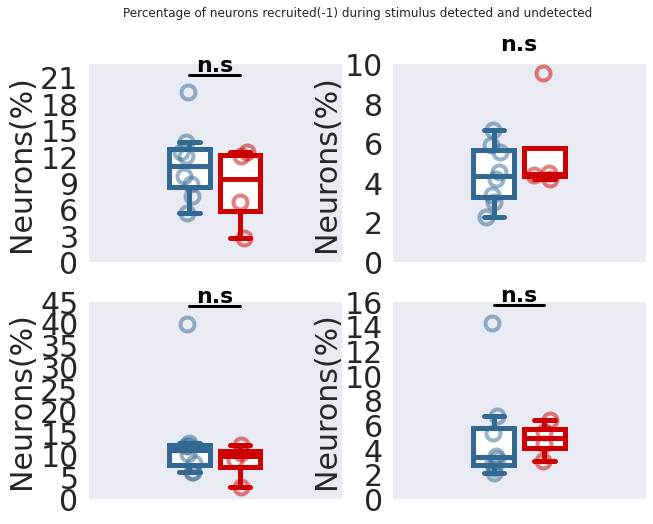

In [7]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=0, n_type="EXC", ko="KO-Hypo")
fig, axs = plt.subplots(2,2,figsize=(10,8))
ppt.boxplot(axs[0,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[0,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=0, n_type="INH", ko="KO-Hypo")
ppt.boxplot(axs[1,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
fig.suptitle("Percentage of neurons recruited(-1) during stimulus detected and undetected")
from matplotlib.ticker import MaxNLocator
axs[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))

## Fraction of neurons activated (1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9193118810653687, pvalue=0.4243049919605255)
ShapiroResult(statistic=0.8952099084854126, pvalue=0.40765753388404846)
LeveneResult(statistic=1.3868624838740555, pvalue=0.2662024263389165)
Equal variances :Ttest_indResult(statistic=0.7479218000385353, pvalue=0.4717299025887792)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9659343361854553, pvalue=0.8643363118171692)
ShapiroResult(statistic=0.6607494354248047, pvalue=0.0036613624542951584)
MannwhitneyuResult(statistic=15.0, pvalue=0.9333333333333333)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8610727787017822, pvalue=0.1230647936463356)
ShapiroResult(statistic=0.8672822117805481, pvalue=0.2871575355529785)
LeveneResult(statistic=0.7637282534590261, pvalue=0.4026636008919525)
Equal variances :Ttest_indResult(statistic=0.9940011465544746, pvalue=0.3436652407558495)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.80793386697769

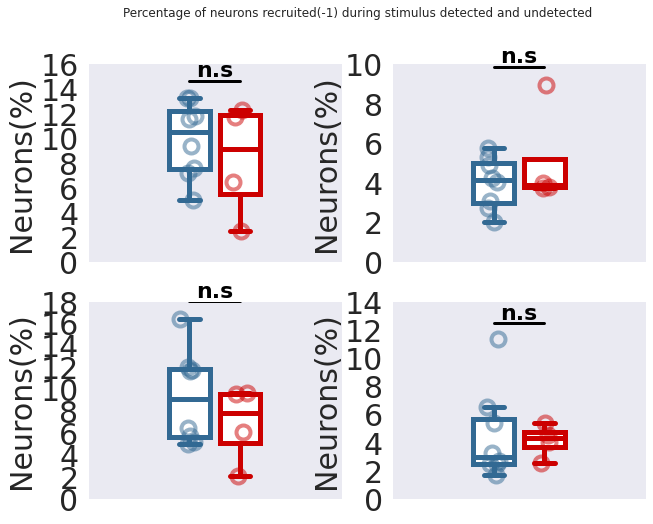

In [8]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=1, n_type="EXC", ko="KO-Hypo")
fig, axs = plt.subplots(2,2,figsize=(10,8))
ppt.boxplot(axs[0,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[0,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=1, n_type="INH", ko="KO-Hypo")
ppt.boxplot(axs[1,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
fig.suptitle("Percentage of neurons recruited(-1) during stimulus detected and undetected")
from matplotlib.ticker import MaxNLocator
axs[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))

## Fraction of neurons inhibited (-1) 

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5672472715377808, pvalue=6.551777187269181e-05)
ShapiroResult(statistic=0.8849709033966064, pvalue=0.3603016436100006)
MannwhitneyuResult(statistic=27.0, pvalue=0.07272727272727274)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8501535058021545, pvalue=0.09561086446046829)
ShapiroResult(statistic=0.9191880226135254, pvalue=0.5324050784111023)
LeveneResult(statistic=0.6585829908811457, pvalue=0.43595119773219354)
Equal variances :Ttest_indResult(statistic=-0.7714421725081906, pvalue=0.4582861156874246)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5439731478691101, pvalue=3.471325180726126e-05)
ShapiroResult(statistic=0.7637908458709717, pvalue=0.051555611193180084)
MannwhitneyuResult(statistic=16.0, pvalue=1.0)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.669510006904602, pvalue=0.0010134369367733598)
ShapiroResult(statistic=0.8720526695251465, pvalue=0.30580320954322815)


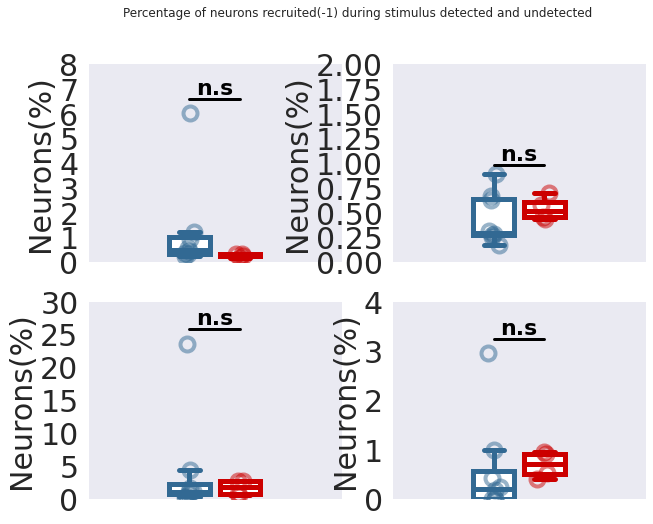

In [9]:
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=-1, n_type="EXC", ko="KO-Hypo")
fig, axs = plt.subplots(2,2,figsize=(10,8))
ppt.boxplot(axs[0,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[0,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=-1, n_type="INH", ko="KO-Hypo")
ppt.boxplot(axs[1,0], wt_det,ko_det,"Neurons(%)",ylim=[])
ppt.boxplot(axs[1,1], wt_undet,ko_undet,"Neurons(%)",ylim=[])
fig.suptitle("Percentage of neurons recruited(-1) during stimulus detected and undetected")
from matplotlib.ticker import MaxNLocator
axs[0,0].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].yaxis.set_major_locator(MaxNLocator(integer=True))


## Fraction of neurons activated (1) for stim amp of 6

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8748777508735657, pvalue=0.1681312471628189)
ShapiroResult(statistic=0.8799018263816833, pvalue=0.33821675181388855)
LeveneResult(statistic=0.4511141127802605, pvalue=0.5170214156188452)
Equal variances :Ttest_indResult(statistic=1.1877634732017794, pvalue=0.2623722088656326)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8748777508735657, pvalue=0.1681312471628189)
ShapiroResult(statistic=0.8799018263816833, pvalue=0.33821675181388855)
LeveneResult(statistic=0.4511141127802605, pvalue=0.5170214156188452)
Equal variances :Ttest_indResult(statistic=1.1877634732017794, pvalue=0.2623722088656326)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8978179097175598, pvalue=0.2761330008506775)
ShapiroResult(statistic=0.8444571495056152, pvalue=0.2087128907442093)
LeveneResult(statistic=1.379120059556013, pvalue=0.26745882864744025)
Equal variances :Ttest_indResult(statistic=1.1476666128015074, pvalue=0

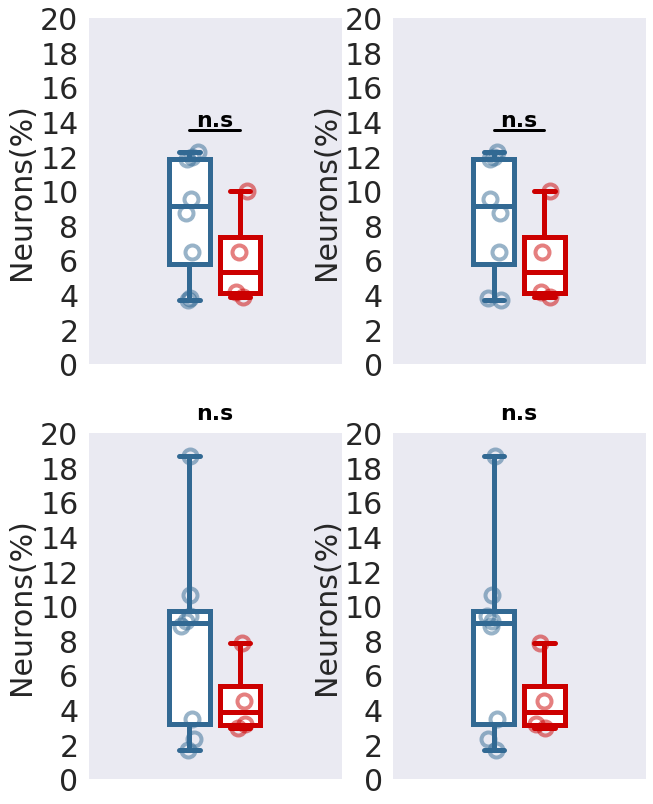

In [10]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,(rec.stim_ampl==6)]
        trials_detected[trials_detected!=1]=0
        recruited_det = np.sum(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if type== "INH":
            total_n = len(rec.zscore_inh)
        perc_n_det = (np.mean(recruited_det)/total_n)*100
        #undetected
        trials_undetected = resp_mat[:,(rec.stim_ampl==6)]
        trials_undetected[trials_undetected!=1]=0
        recruited_undet = np.sum(trials_undetected,axis=0)
        perc_n_undet = (np.mean(recruited_undet)/total_n)*100
        if rec.genotype == "WT":
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet)
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.boxplot(axs[i,0], wt_det,ko_det,"Neurons(%)",ylim=[0,20])
    ppt.boxplot(axs[i,1], wt_undet,ko_undet,"Neurons(%)",ylim=[0,20])
    axs[i,0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))

# Comparison group det vs group undet


## Fraction of neurons recruited (1 and -1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9563702940940857, pvalue=0.7749032378196716)
ShapiroResult(statistic=0.96978360414505, pvalue=0.8963048458099365)
Ttest_relResult(statistic=4.654817045675658, pvalue=0.0023286468491326)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8880429267883301, pvalue=0.37412503361701965)
ShapiroResult(statistic=0.6697325706481934, pvalue=0.004861507099121809)
WilcoxonResult(statistic=1.0, pvalue=0.25)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.6384268403053284, pvalue=0.00044495885958895087)
ShapiroResult(statistic=0.7365221977233887, pvalue=0.005788878072053194)
WilcoxonResult(statistic=0.0, pvalue=0.0078125)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9040603637695312, pvalue=0.45150598883628845)
ShapiroResult(statistic=0.9899246096611023, pvalue=0.9570812582969666)
Ttest_relResult(statistic=2.264110744548199, pvalue=0.10851318325261451)


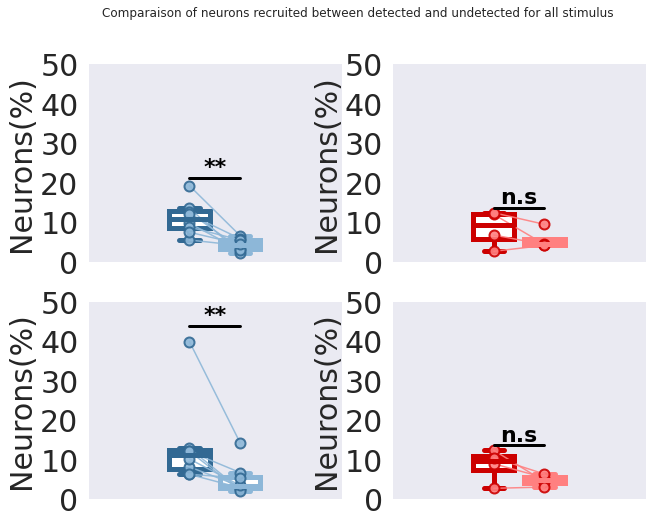

In [11]:
fig, axs = plt.subplots(2,2,figsize=(10,8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp( pattern=0, n_type=type, ko="KO-Hypo")
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)","",ylim=[0,50],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)","",ylim=[0,50])
    fig.suptitle("Comparaison of neurons recruited between detected and undetected for all stimulus")


## Fraction of neurons activated(1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9193118810653687, pvalue=0.4243049919605255)
ShapiroResult(statistic=0.9659343361854553, pvalue=0.8643363118171692)
Ttest_relResult(statistic=4.889255050216311, pvalue=0.0017747535100957348)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8952099084854126, pvalue=0.40765753388404846)
ShapiroResult(statistic=0.6607494354248047, pvalue=0.0036613624542951584)
WilcoxonResult(statistic=1.0, pvalue=0.25)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8610727787017822, pvalue=0.1230647936463356)
ShapiroResult(statistic=0.8079338669776917, pvalue=0.034785471856594086)
WilcoxonResult(statistic=1.0, pvalue=0.015625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8672822117805481, pvalue=0.2871575355529785)
ShapiroResult(statistic=0.9716790914535522, pvalue=0.8518524765968323)
Ttest_relResult(statistic=2.0279950945026806, pvalue=0.13560587748668945)


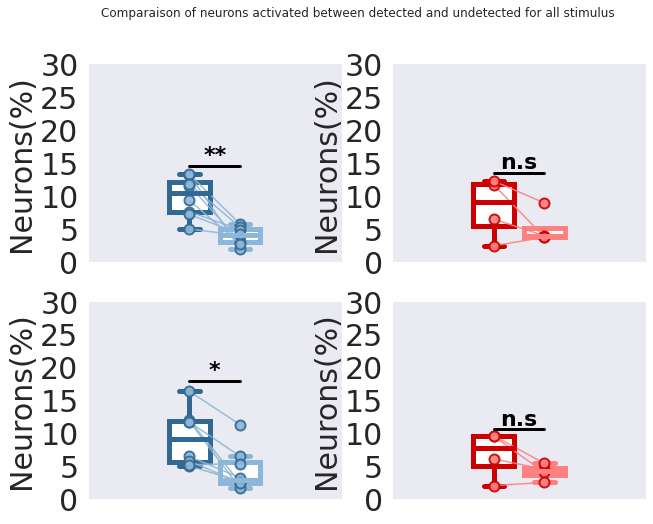

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=1, n_type=type, ko="KO-Hypo")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", "", ylim=[0, 30],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", "", ylim=[0, 30])
    fig.suptitle("Comparaison of neurons activated between detected and undetected for all stimulus")

## Fraction of neurons inhibited (-1)

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5672472715377808, pvalue=6.551777187269181e-05)
ShapiroResult(statistic=0.8501535058021545, pvalue=0.09561086446046829)
WilcoxonResult(statistic=5.0, pvalue=0.078125)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.8849709033966064, pvalue=0.3603016436100006)
ShapiroResult(statistic=0.9191880226135254, pvalue=0.5324050784111023)
Ttest_relResult(statistic=-3.8311777072827935, pvalue=0.03133552688318168)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.5439731478691101, pvalue=3.471325180726126e-05)
ShapiroResult(statistic=0.669510006904602, pvalue=0.0010134369367733598)
WilcoxonResult(statistic=1.0, pvalue=0.015625)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7637908458709717, pvalue=0.051555611193180084)
ShapiroResult(statistic=0.8720526695251465, pvalue=0.30580320954322815)
Ttest_relResult(statistic=1.7370169807171132, pvalue=0.1807800607132298)


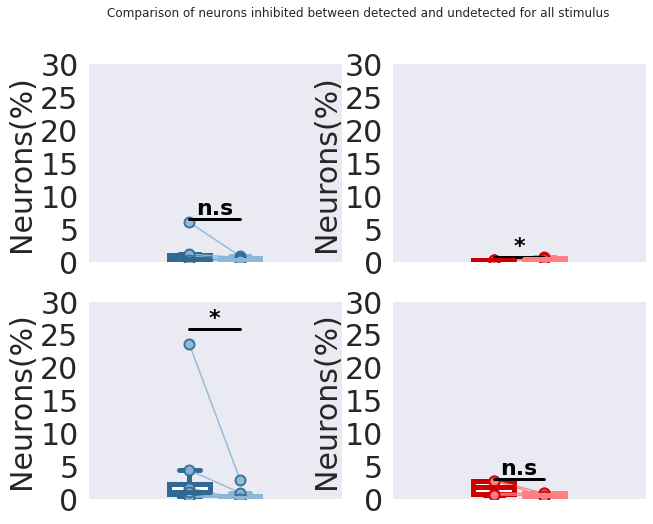

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
for i, type in enumerate(["EXC", "INH"]):
    wt_det, ko_det, wt_undet, ko_undet = fraction_resp(pattern=-1, n_type=type, ko="KO-Hypo")
    ppt.paired_boxplot(axs[i, 0], wt_det, wt_undet, "Neurons(%)", "", ylim=[0, 30],
                       colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i, 1], ko_det, ko_undet, "Neurons(%)", "", ylim=[0, 30])
    fig.suptitle("Comparison of neurons inhibited between detected and undetected for all stimulus")

## Fraction of neurons activated between detected and undected at THRESHOLD stimulus

Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9353227615356445, pvalue=0.5657245516777039)
ShapiroResult(statistic=0.7966114282608032, pvalue=0.026328910142183304)
WilcoxonResult(statistic=0.0, pvalue=0.0078125)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9510063529014587, pvalue=0.7224069237709045)
ShapiroResult(statistic=0.9298439621925354, pvalue=0.5934824347496033)
Ttest_relResult(statistic=0.3316254597335317, pvalue=0.7619881940921759)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.9225273728370667, pvalue=0.4507051706314087)
ShapiroResult(statistic=0.8568943738937378, pvalue=0.11179383099079132)
Ttest_relResult(statistic=1.268516845330349, pvalue=0.2451679644490724)
Boxplot plotting.
--- Neurons(%) ---
ShapiroResult(statistic=0.7800793647766113, pvalue=0.07103117555379868)
ShapiroResult(statistic=0.894442081451416, pvalue=0.40397968888282776)
Ttest_relResult(statistic=0.22504334776224144, pvalue=0.836403437188371)


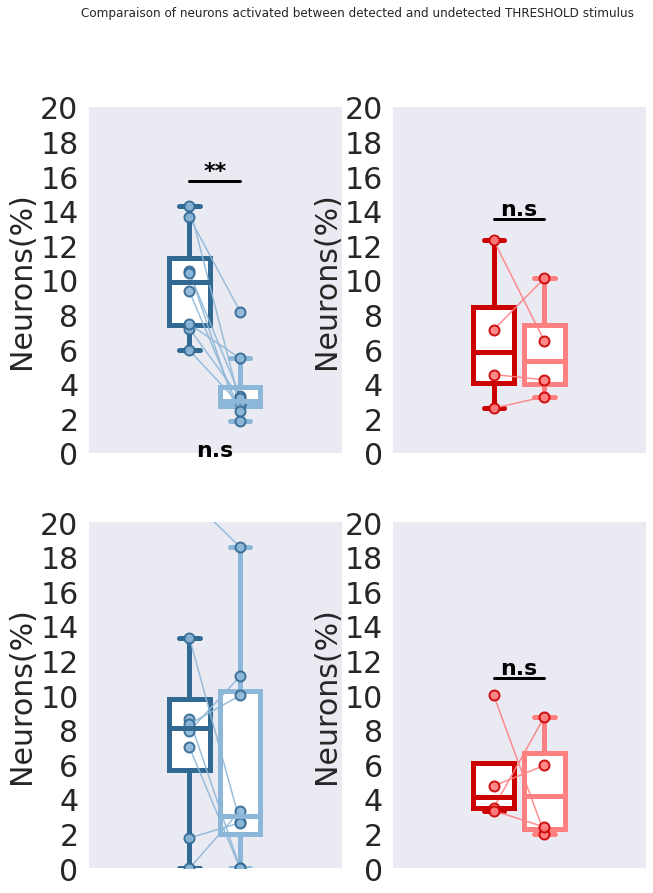

In [14]:
fig, axs = plt.subplots(2,2,figsize=(10,14))

for i,type in enumerate(["EXC","INH"]):
    wt_det, wt_undet, ko_det, ko_undet = [],[],[],[]
    for rec in recs.values():
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        #detected
        trials_detected = resp_mat[:,rec.detected_stim& (rec.stim_ampl==rec.threshold)]
        trials_detected[trials_detected!=1]=0
        recruited_det = np.sum(trials_detected,axis=0)
        total_n = len(rec.zscore_exc)
        if type== "INH":
            total_n = len(rec.zscore_inh)
        perc_n_det = (np.mean(recruited_det)/total_n)*100
        #undetected
        trials_undetected = resp_mat[:,~rec.detected_stim & (rec.stim_ampl==rec.threshold)]
        trials_undetected[trials_undetected!=1]=0
       
        recruited_undet = np.sum(trials_undetected,axis=0)
       
        perc_n_undet = (np.mean(recruited_undet)/total_n)*100
        if rec.genotype == "WT" :
            wt_det.append(perc_n_det)
            wt_undet.append(perc_n_undet )
        elif rec.genotype =="KO-Hypo":
            ko_det.append(perc_n_det)
            ko_undet.append(perc_n_undet)
    ppt.paired_boxplot(axs[i,0], wt_det,wt_undet,"Neurons(%)","",ylim=[0,20],colors=[ppt.wt_color, ppt.light_wt_color])
    ppt.paired_boxplot(axs[i,1], ko_det,ko_undet,"Neurons(%)","",ylim=[0,20])
    fig.suptitle("Comparaison of neurons activated between detected and undetected THRESHOLD stimulus")
    axs[i,0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[i,1].yaxis.set_major_locator(MaxNLocator(integer=True))

# Responsivity per amplitude line graphs 22/03/2024  

## Graph of activated neurons from amplitude

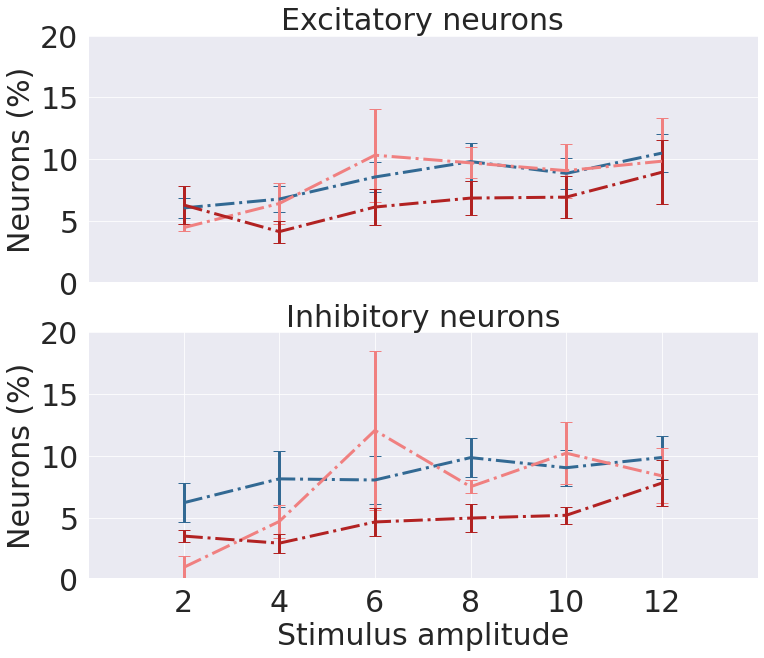

In [15]:
import scipy.stats as ss
figs, axs = plt.subplots(2,1,figsize=(12,10))
from matplotlib.ticker import AutoMinorLocator
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}

amps=[2,4,6,8,10,12]
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        # rec.responsivity()
        resp_mat = np.array(rec.matrices[type]["Responsivity"])
        resp_p=[]
        for amp in amps:
            trials_detected = resp_mat[:,rec.stim_ampl==amp]
            trials_detected[trials_detected!=1]=0
            recruited_det = np.sum(trials_detected,axis=0)
            total_n = len(rec.zscore_exc)
            if type== "INH":
                total_n = len(rec.zscore_inh)
            perc_n_det = (np.mean(recruited_det)/total_n)*100
            if np.isfinite(perc_n_det):
                resp_p.append(perc_n_det)
            else: 
                resp_p.append(0)
        if rec.genotype == "WT":
            wt.append(resp_p)
        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(resp_p)
        elif rec.genotype =="KO":
            ko.append(resp_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw =3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(ko,axis=0),capsize=6,markersize=15, lw =3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(ko_hypo,axis=0),capsize=6,markersize=15, lw =3)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[i].tick_params(axis='both', which='major', length=6, width=3)
    axs[i].tick_params(axis='both', which='minor', length=4, width=3)
    axs[i].set_ylabel("Neurons (%)", fontsize = 30)
    axs[i].set_xlabel("Stimulus amplitude", fontsize = 30)
    axs[i].set_xlim([0,14])
    axs[i].set_ylim([0,20])
    axs[i].set_title(labels[type], fontsize =30)
    axs[i].tick_params(axis='both', labelsize=30)
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].spines[['right', 'top',]].set_visible(False)
    axs[0].get_xaxis().set_visible(False)

## Graph of amplitude response from each stimulus amplitude


/tmp/ipykernel_944812/409611497.py:16: RuntimeWarning: Mean of empty slice
  output = np.nanmean(np.nanmean(trials, axis=1))
/tmp/ipykernel_944812/409611497.py:16: RuntimeWarning: Mean of empty slice
  output = np.nanmean(np.nanmean(trials, axis=1))


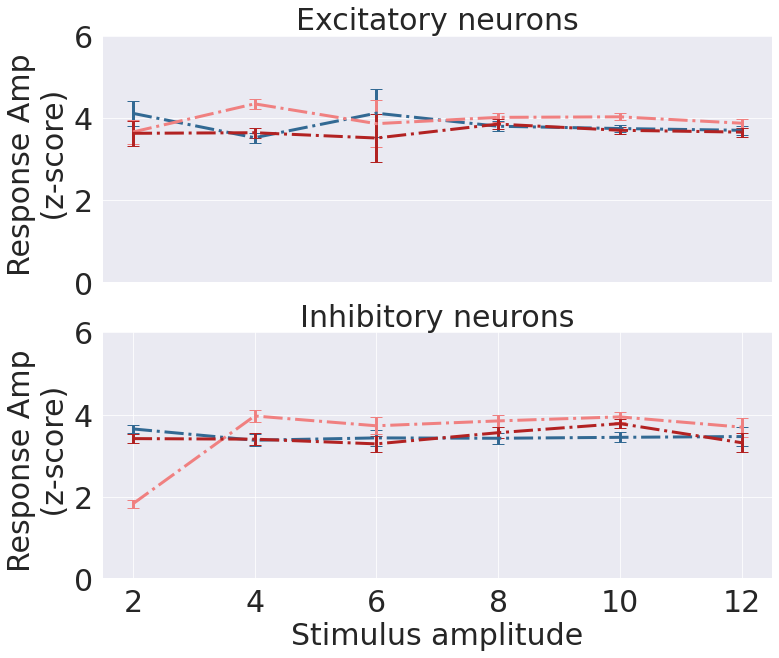

In [16]:
import scipy.stats as ss
figs, axs = plt.subplots(2,1,figsize=(12,10))

amps=[2,4,6,8,10,12]
labels = {"EXC":"Excitatory neurons" , "INH": "Inhibitory neurons"}
for i,type in enumerate(["EXC","INH"]):
    wt,ko, ko_hypo = [],[],[]
    for rec in recs.values():
        rec.peak_delay_amp()
        mat = np.array(rec.matrices[type]["Peak_amplitude"])
        mat[mat<0]=np.nan

        _p=[]
        for amp in amps:
            trials = mat[:,rec.stim_ampl==amp]
            output = np.nanmean(np.nanmean(trials, axis=1))
            if np.isnan(output ):
                output = 0
            _p.append( output)
            
        if rec.genotype == "WT":
            wt.append(_p)

        elif rec.genotype =="KO-Hypo":
            ko_hypo.append(_p)
        elif rec.genotype =="KO":
            ko.append(_p)
        
    axs[i].errorbar(amps,np.mean(wt,axis=0),linestyle="-.",color="#326993",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko,axis=0),linestyle="-.", color="lightcoral",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].errorbar(amps,np.mean(ko_hypo,axis=0),linestyle="-.", color="firebrick",yerr=ss.sem(wt,axis=0),capsize=6,markersize=15, lw=3)
    axs[i].yaxis.set_minor_locator(AutoMinorLocator(2))
    axs[i].tick_params(axis='both', which='major', length=6, width=3)
    axs[i].tick_params(axis='both', which='minor', length=4, width=3)
    axs[i].set_ylabel("Response Amp \n (z-score)", fontsize =30)
    axs[i].set_xlabel("Stimulus amplitude", fontsize =30)
    axs[i].set_title(labels[type], fontsize =30)
    axs[i].tick_params(axis='both', labelsize=30)
    axs[i].set_xticks([2,4,6,8,10,12])
    axs[i].set_ylim([0,6])
    axs[i].spines[['right', 'top',]].set_visible(False)
axs[0].get_xaxis().set_visible(False)

# Psychometric curves like graphs for fraction of resp neurons

Number of active neurons and behavior psychometric curves comparison animal by animals

Text(0.5, 0.98, 'Percentage of neurons recruited for all trials amplitude')

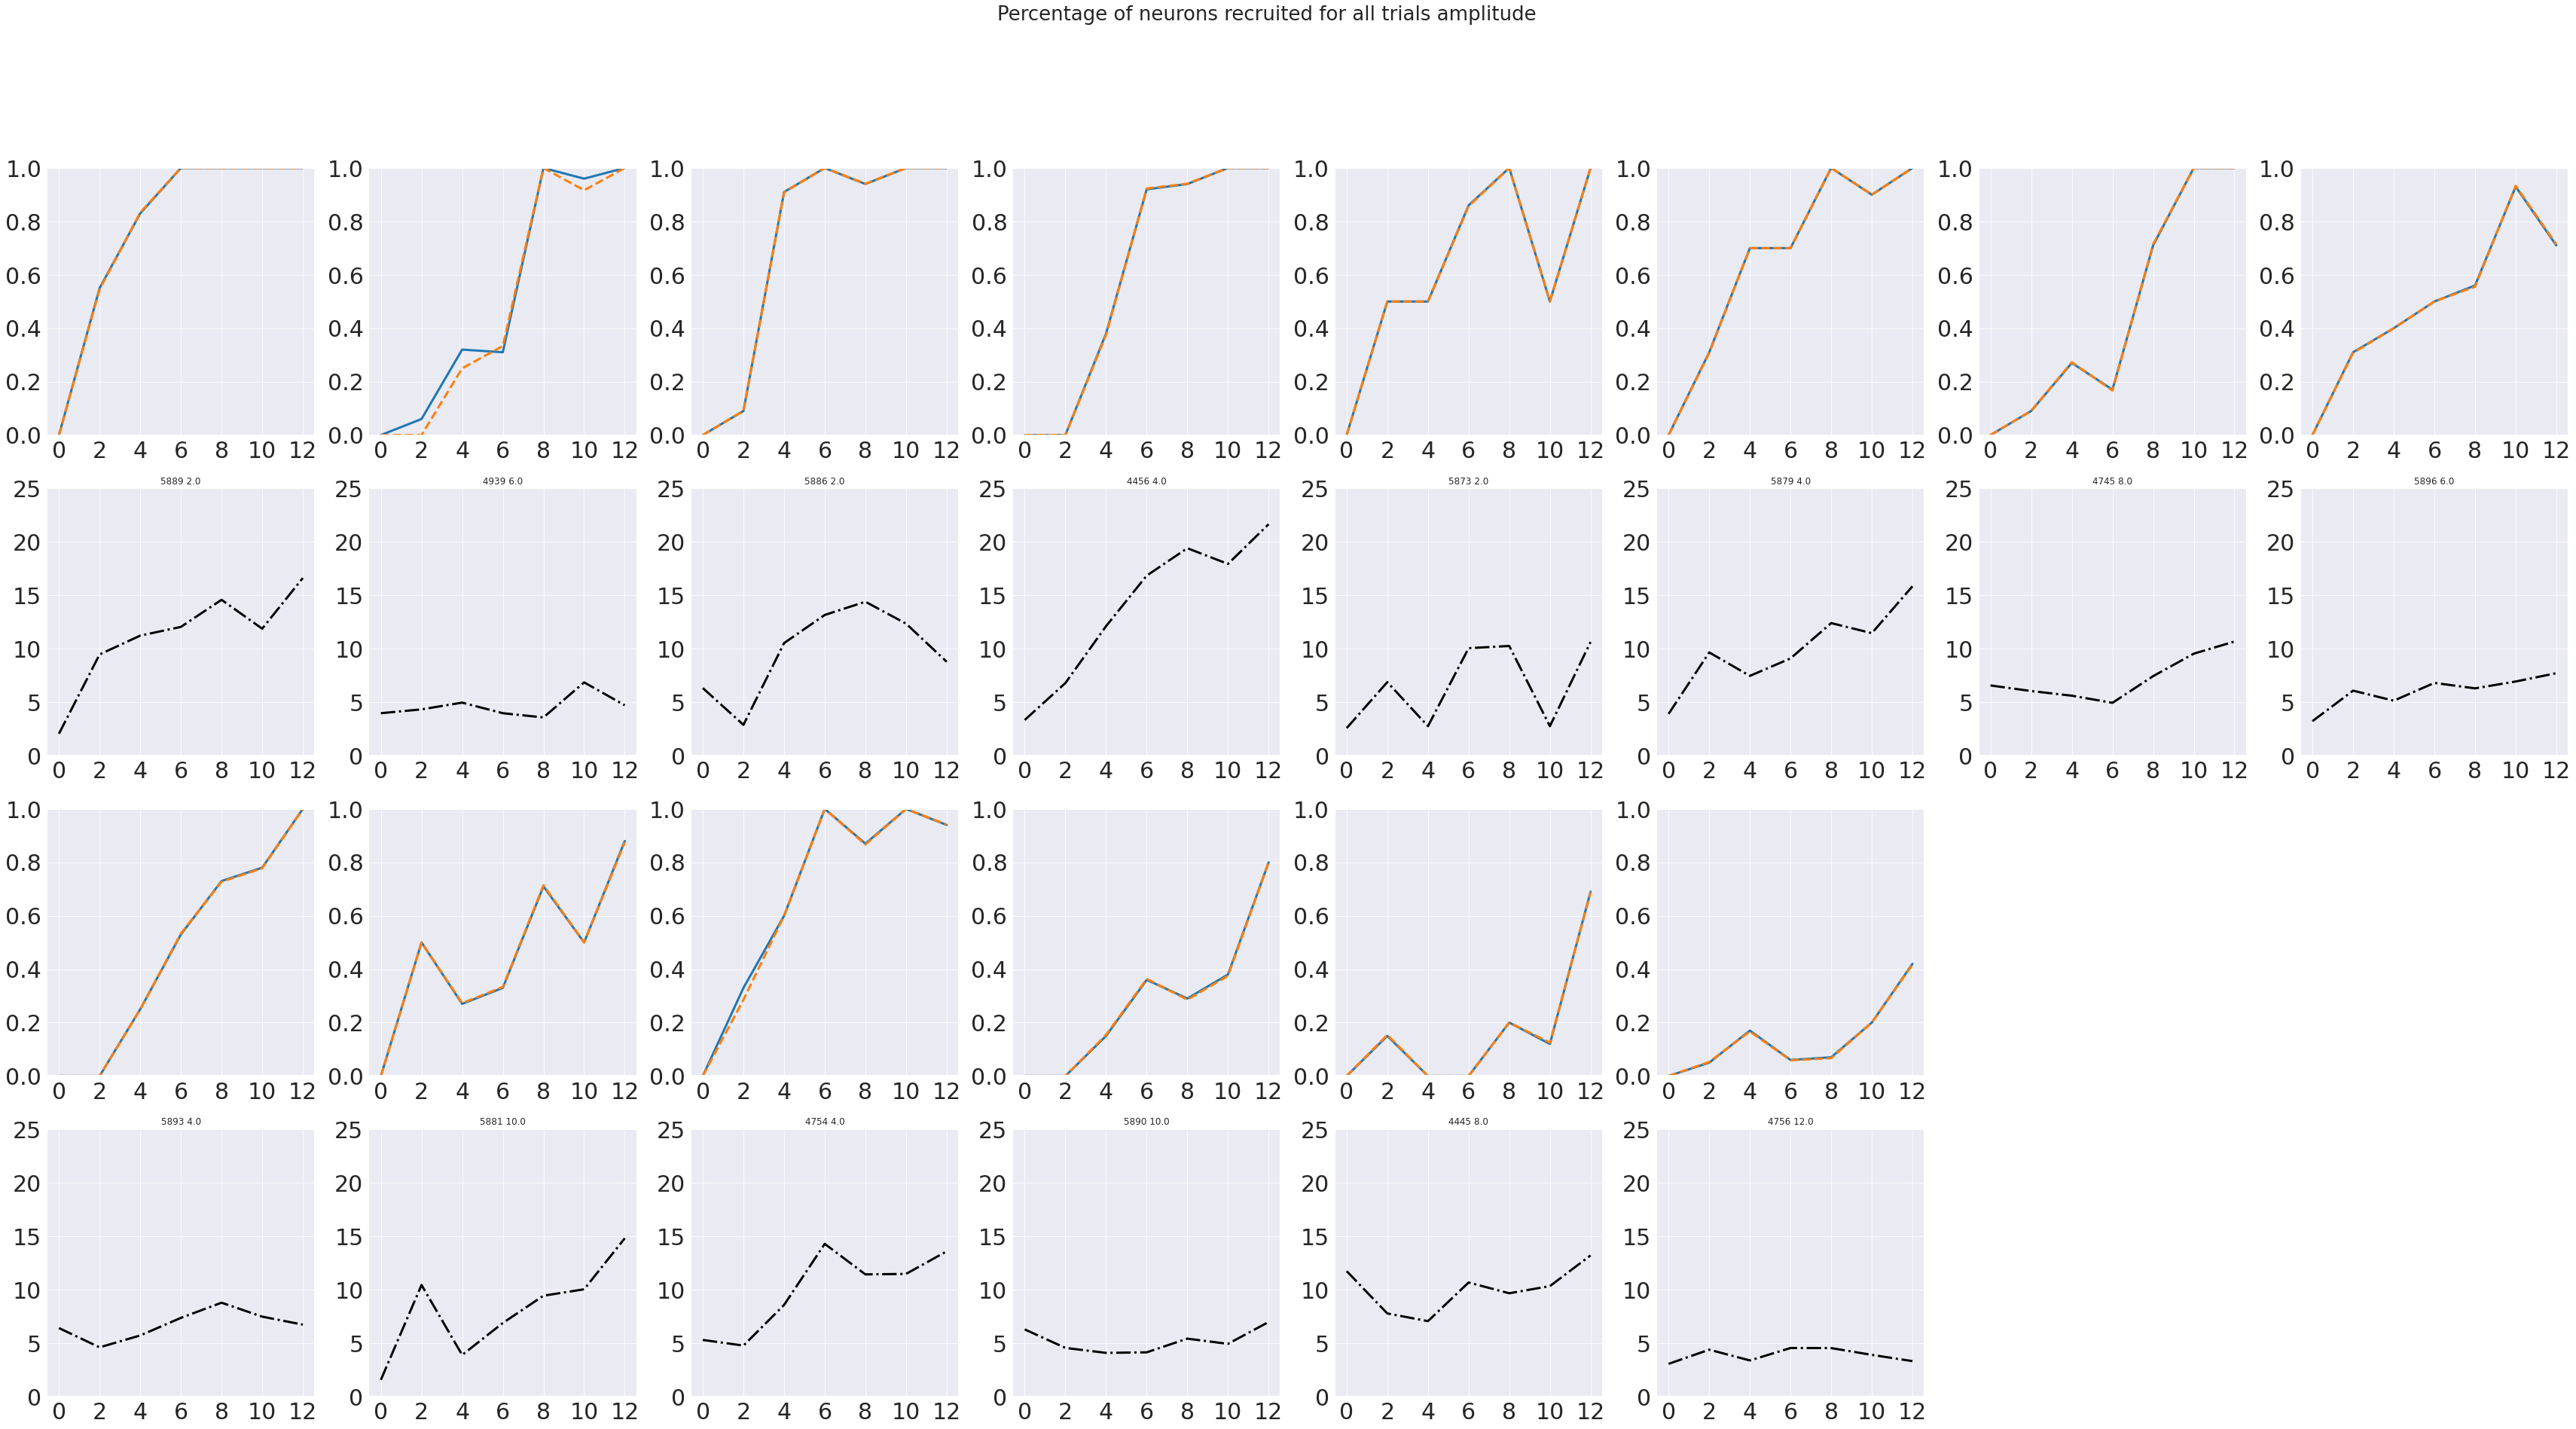

In [17]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, rec_.stim_ampl == amp]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for all trials amplitude', fontsize=26)

/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/datas/Théo/Spikesorting/venv/Spikesorting2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Percentage of neurons recruited for DETECTED TRIALS')

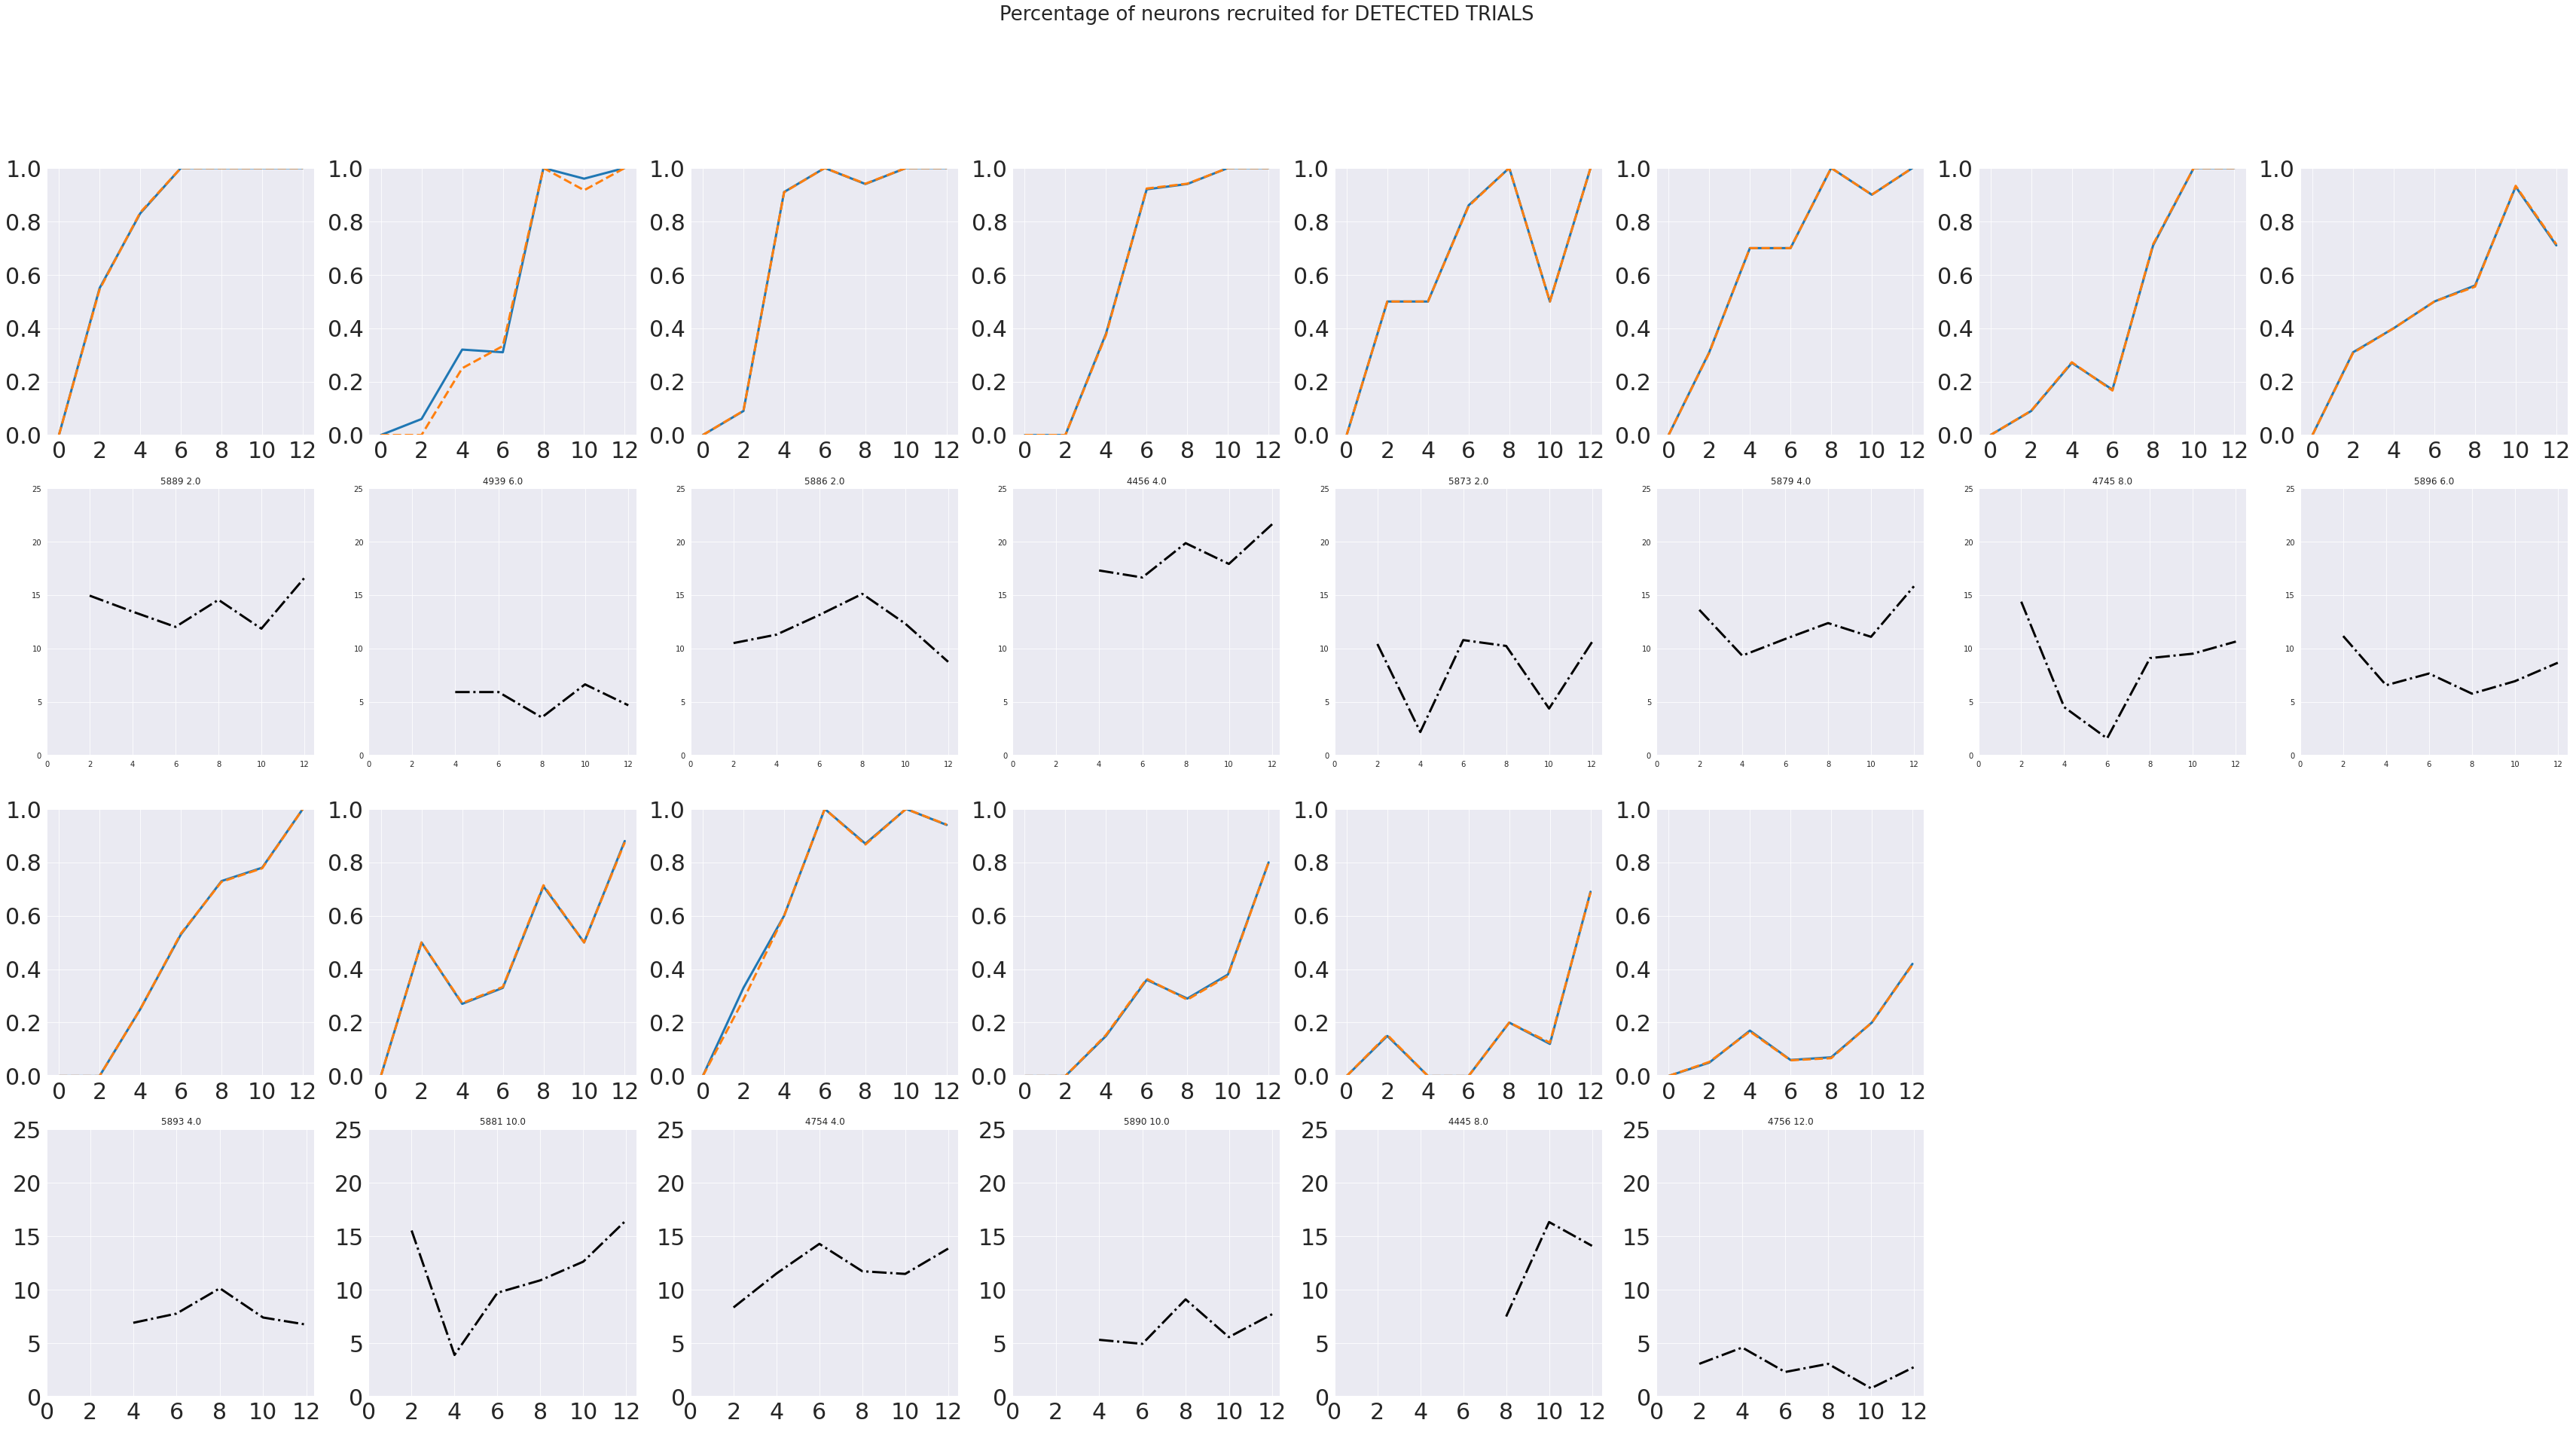

In [18]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 1] = 0
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    nb_trials= []
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
        nb_trials.append(len(rec.stim_ampl[rec.stim_ampl == amp]))
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    # ax.bar([0, 2, 4, 6, 8, 10, 12], nb_trials)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])
            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()
fig.suptitle('Percentage of neurons recruited for DETECTED TRIALS', fontsize=26)

percentage of neurons recruited for UNDETECTED TRIALS

5889
4939
5893
5886
4456
5873
5881
5879
4754
5890
4745
5896
4445
4756


Text(0.5, 0.98, 'Percentage of neurons recruited for UNDETECTED TRIALS')

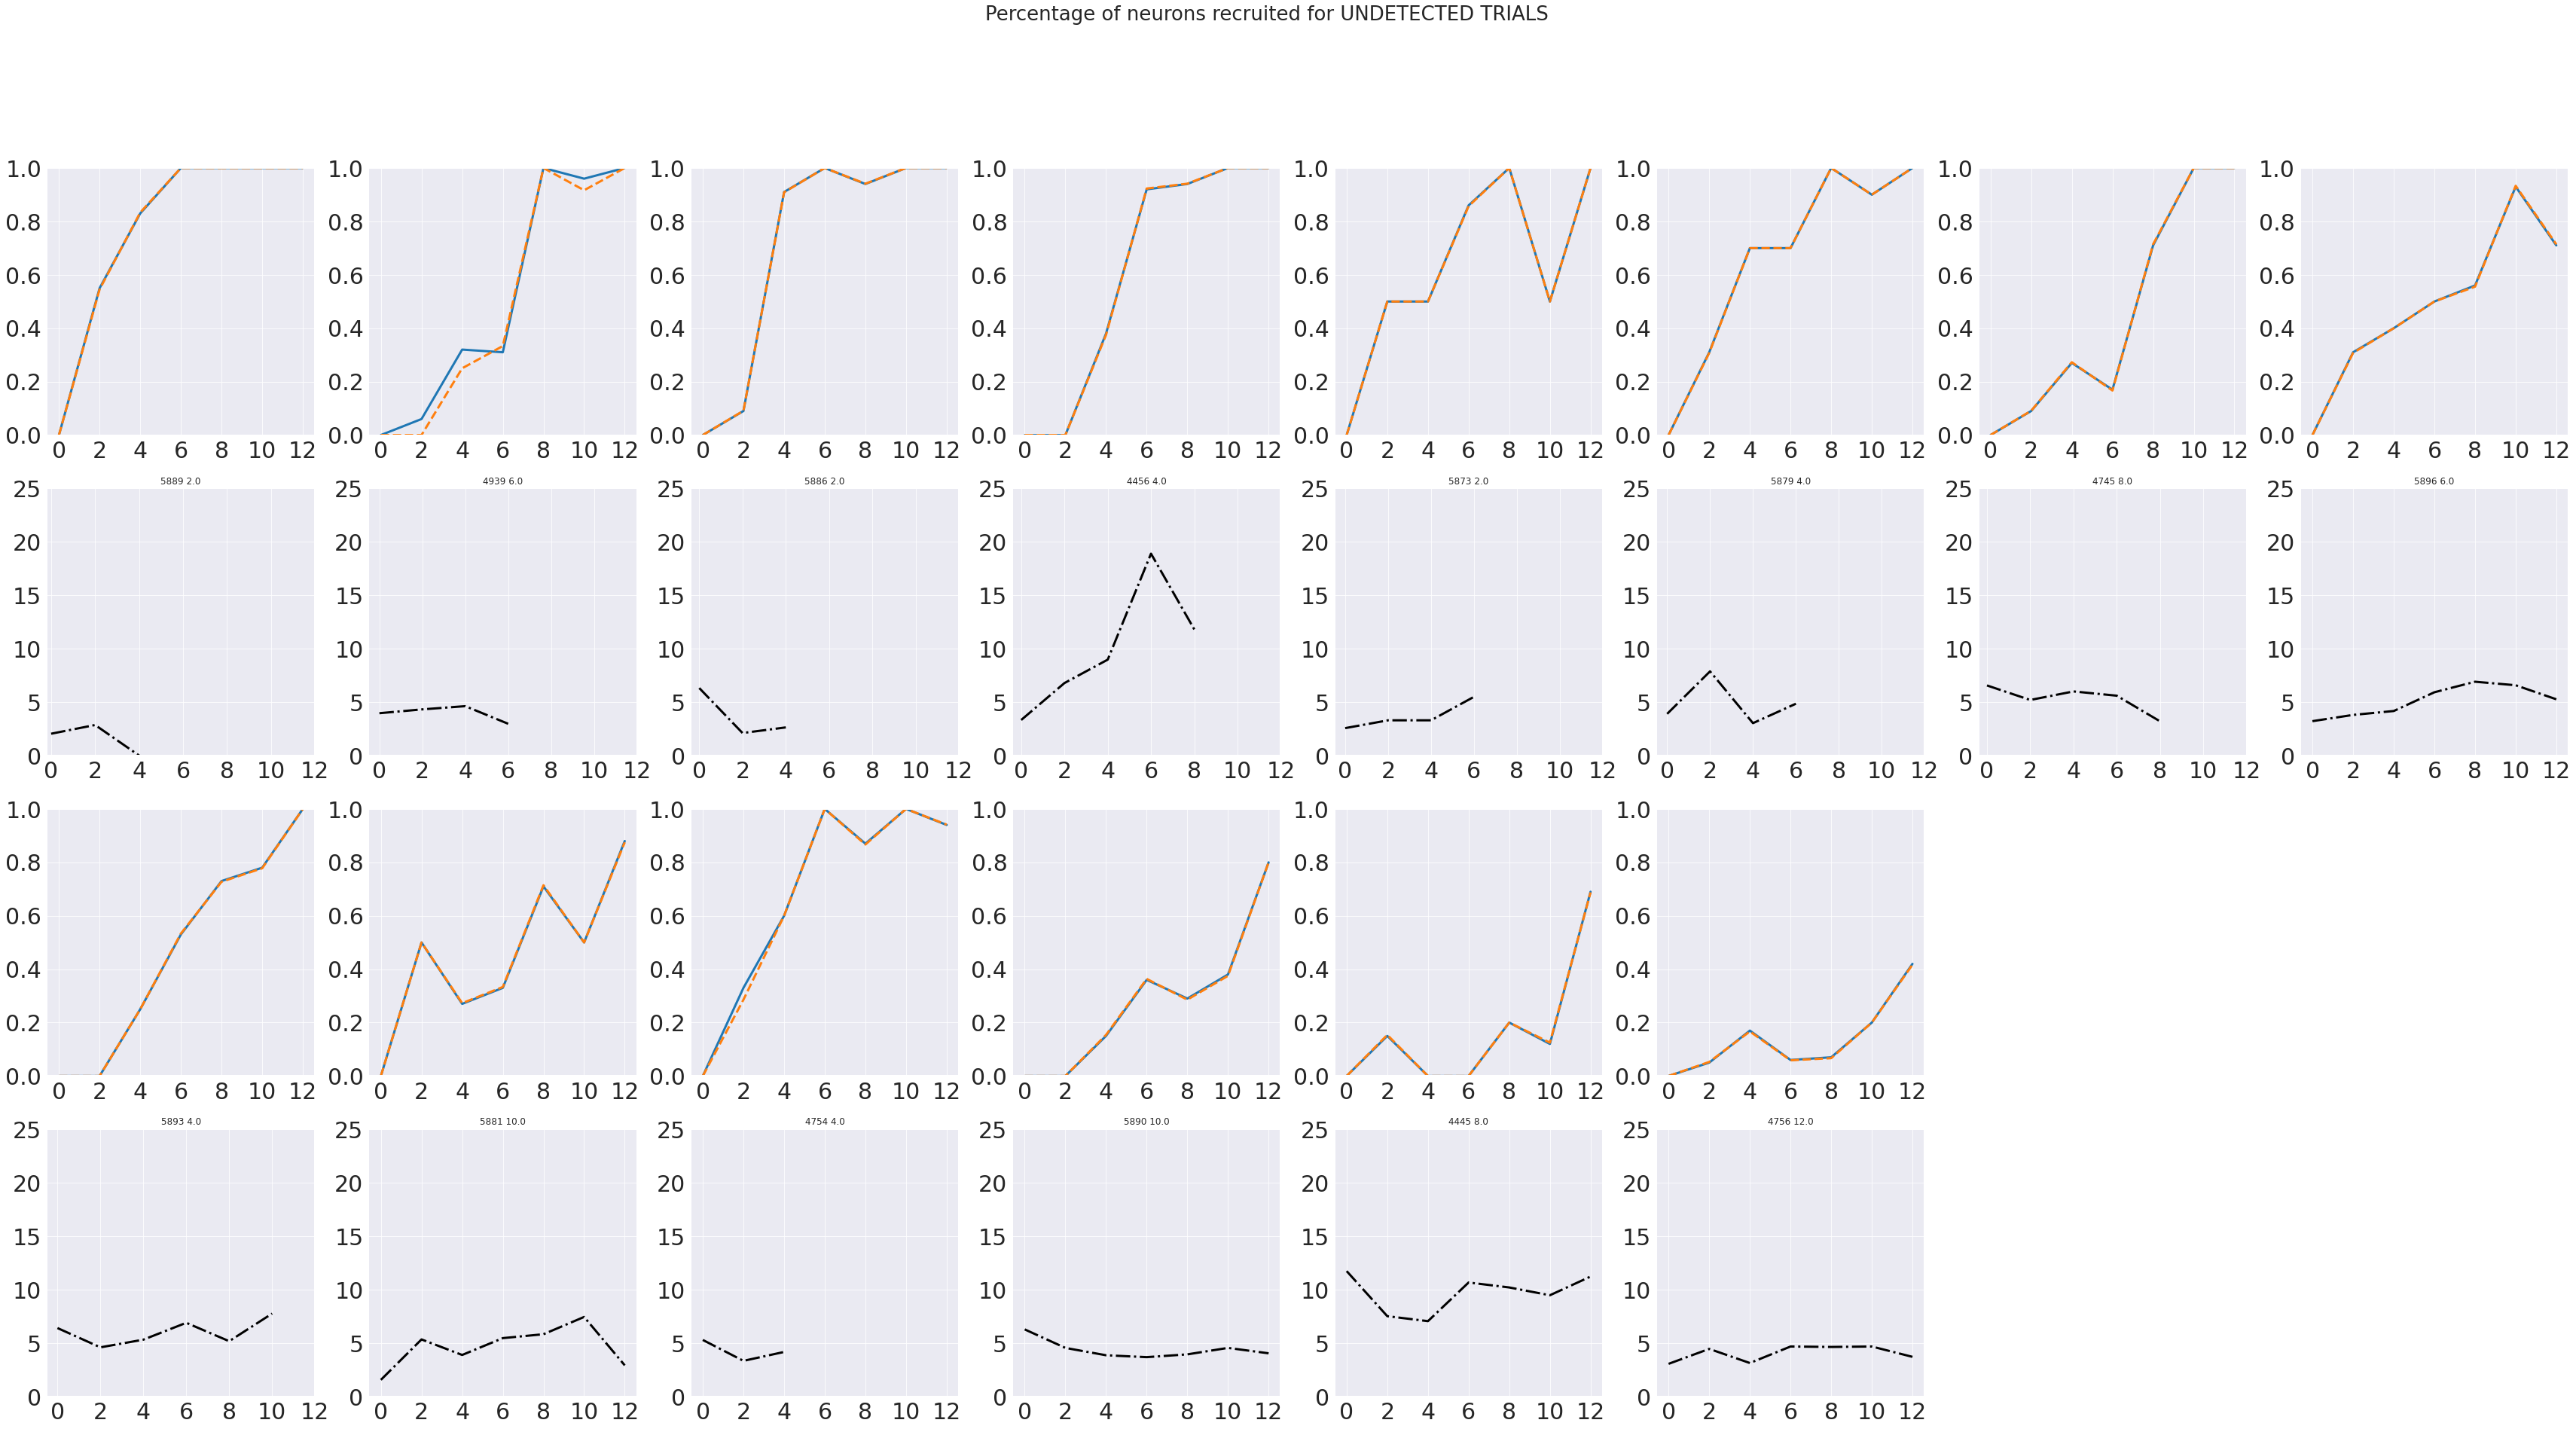

In [19]:
y, i = 0, 0
amps = [0, 2, 4, 6, 8, 10, 12]
fig, ax = plt.subplots(4, 8, figsize=(60, 30))

def neurons_recruited(ax, rec_, title):
    resp_mat = np.array(rec_.matrices["EXC"]["Responsivity"])
    resp_p = []
    trials_bsl = resp_mat[:, rec_.stim_ampl == 0]
    trials_bsl[trials_bsl != 0] = 1
    bsl_neurons = np.mean(np.count_nonzero(trials_bsl, axis=0))
    for i, amp in enumerate(amps):
        trials_ = resp_mat[:, (rec_.stim_ampl == amp)&(~rec_.detected_stim)]
        trials_[trials_ != 0] = 1
        recruited_det = np.count_nonzero(trials_, axis=0)
        perc_n_det = ((np.mean(recruited_det)) / len(rec_.zscore_exc)) * 100
        resp_p.append(perc_n_det)
    ax.plot(amps, resp_p, linestyle="-.", color="black",
                        markersize=15)
    ax.set_title(title)
    ax.set_ylim([0,25])
for rec in recs.values():
        print(rec.filename)
        # rec.responsivity()
        if rec.genotype == "WT":
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[0, i])
            neurons_recruited(ax[1, i], rec,str(rec.filename) + " " +str(rec.threshold))
            ax[0, i].tick_params(axis='both', labelsize=30)
            ax[1, i].tick_params(axis='both', labelsize=30)
            ax[1, i].set_xticks([0,2,4,6,8,10,12])

            i = i + 1
        else:
            pbh.psycho_like_plot_and_synchro(rec, roi_info, ax[2, y])
            neurons_recruited(ax[3, y], rec, str(rec.filename) + " " +str(rec.threshold))
            ax[2, y].tick_params(axis='both', labelsize=30)
            ax[3, y].tick_params(axis='both', labelsize=30)
            ax[3, y].set_xticks([0,2,4,6,8,10,12])
            y = y + 1
ax[2, 6].set_axis_off()
ax[2, 7].set_axis_off()
ax[3, 6].set_axis_off()
ax[3, 7].set_axis_off()


fig.suptitle('Percentage of neurons recruited for UNDETECTED TRIALS', fontsize=26)